In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (20,3)

In [5]:
pd.set_option('display.max_columns', 500)

In [7]:
if False:
    #read scraped data in
    df = pd.read_csv('data/metadata.csv', sep=';').drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)

# Read in DK postnumre

In [8]:
postnumre = gpd.read_file('data/postnumre.geojson')
#postnumre.plot()

#store postal codes
cph_postals = set(df.postal.tolist())

post = set()
for x in postnumre['POSTNR_TXT'].tolist():
    try:
        #convert string to int
        x = int(x)
        
        #add to set
        post.add(x)
    except:
        #postnumre with - to show multiple numbers
        # like 1800-1999 (Frederiksberg C)
        
        #split on dash
        x,y = x.split('-')
        
        #convert to integers
        x,y = int(x),int(y)
        
        #add all postal codes from x to y
        for i in range(x,y+1):
            post.add(i)

#get intersect between our scraped data and the above
intersect = post.intersection(cph_postals)

#check that we don't have faulty zip codes in our data
print('{} zip codes are not in the postnumre data'.format(len(cph_postals - intersect)))

postal_strings = set()
#filter the postnumre and show what's left
for x in postnumre['POSTNR_TXT'].tolist():
    try:
        if int(x) in intersect:
            postal_strings.add(x)
    except:
        if '-' in x:
            y,z = x.split('-')
            if y or z in intersect:
                postal_strings.add(x)
        print('Not in the data',x)

0 zip codes are not in the postnumre data
Not in the data 1000-1499
Not in the data 1000-1499
Not in the data 1000-1499
Not in the data 1000-1499
Not in the data 1000-1499
Not in the data 1800-1999
Not in the data 1500-1799
Not in the data 1500-1799


In [9]:
#filter the postnumre based on the zip codes
filtered_postnumre = postnumre[postnumre['POSTNR_TXT'].isin(postal_strings)]

In [10]:
filtered_postnumre.head()

,POSTNR_TXT,POSTBYNAVN,geometry
0,2800,Kongens Lyngby,"POLYGON Z ((12.50455 55.80083 -999.00000, 12.5..."
7,2740,Skovlunde,"POLYGON Z ((12.37088 55.70269 -999.00000, 12.3..."
19,1000-1499,København K,"POLYGON Z ((12.57779 55.67076 -999.00000, 12.5..."
20,1000-1499,København K,"POLYGON Z ((12.58973 55.66791 -999.00000, 12.5..."
21,1000-1499,København K,"POLYGON Z ((12.61383 55.70149 -999.00000, 12.6..."


## Fix Kbh_K, Kbh_V to include individual zip codes
* Both municipalities have a lot of zip codes but they are not written explicitly

In [12]:
filtered_postnumre[filtered_postnumre['POSTBYNAVN'] == 'København K']

,POSTNR_TXT,POSTBYNAVN,geometry
19,1000-1499,København K,"POLYGON Z ((12.57779 55.67076 -999.00000, 12.5..."
20,1000-1499,København K,"POLYGON Z ((12.58973 55.66791 -999.00000, 12.5..."
21,1000-1499,København K,"POLYGON Z ((12.61383 55.70149 -999.00000, 12.6..."
22,1000-1499,København K,"POLYGON Z ((12.72910 55.70326 -999.00000, 12.7..."
23,1000-1499,København K,"POLYGON Z ((12.66654 55.71938 -999.00000, 12.6..."


In [14]:
filtered_postnumre[filtered_postnumre['POSTBYNAVN'] == 'København V']

,POSTNR_TXT,POSTBYNAVN,geometry
491,1500-1799,København V,"POLYGON Z ((12.56048 55.66027 -999.00000, 12.5..."
532,1500-1799,København V,"POLYGON Z ((12.53055 55.66303 -999.00000, 12.5..."


In [16]:
#store one row for each municipality
kbh_V_row = filtered_postnumre.iloc[[32]]
kbh_k_row = filtered_postnumre.iloc[[2]]

In [17]:
#split the zip into two integers from 1000-1499
zip_range_Kbh_K = [int(x) for x in kbh_k_row['POSTNR_TXT'].values.tolist()[0].split('-')]

#store the two ints
range_start, range_end = zip_range_Kbh_K[0],zip_range_Kbh_K[1]+1

#dict to store the data
postnumre_K = {'id':[],'POSTBYNAVN':[],'POSTNR_TXT':[],'geometry':[]}

#for each zip between range_start and range_end
#append to each list in our postnumre_K dict
for postal in range(range_start,range_end):
    postnumre_K['id'].append(postal)
    postnumre_K['POSTNR_TXT'].append(str(postal))
    postnumre_K['POSTBYNAVN'].append('København K')
    postnumre_K['geometry'].append(kbh_k_row['geometry'].tolist()[0])

In [21]:
#same as above but for Kbh V
zip_range_Kbh_V = [int(x) for x in kbh_V_row['POSTNR_TXT'].values.tolist()[0].split('-')]

range_start, range_end = zip_range_Kbh_V[0],zip_range_Kbh_V[1]+1

postnumre_V = {'id':[],'POSTBYNAVN':[],'POSTNR_TXT':[],'geometry':[]}

for postal in range(range_start,range_end):
    postnumre_V['id'].append(postal)
    postnumre_V['POSTNR_TXT'].append(str(postal))
    postnumre_V['POSTBYNAVN'].append('København V')
    postnumre_V['geometry'].append(kbh_V_row['geometry'].tolist()[0])

In [23]:
#convert the two dicts to dataframes and 
#concat the two frames with the filtered_postnumre
#to get final filtered postnumre geojson
new = pd.concat([pd.DataFrame(filtered_postnumre),pd.DataFrame(kbh_k),pd.DataFrame(postnumre_V)])

In [24]:
#check to see lengths
print(len(filtered_postnumre),len(new))

47 846


In [25]:
#convert to geopandas
new_gdf = gpd.GeoDataFrame(new)

#and write to file
with open('data/postnumre_filtered_v2.geojson', 'w') as out:
    out.write(new_gdf.to_json())

## OSM Export

In [7]:
#read in 
extra = gpd.read_file('data/export.geojson')


#keep only OSM data that is within the postnumre we have
filterz = []

#for each polygon in the OSM export
for poly in extra.geometry.tolist(): 
    found = False
    
    #check against each polygon in our postnumre data
    for i in new_gdf.geometry.tolist():
        
        #if the two polygons intersect
        if poly.intersects(i):
            
            #the osm entity is in the capital region
            #so keep it and break
            filterz.append(True)
            found = True
            break
    #if we haven't found the entity at all
    if not found:
        #drop the row
        filterz.append(False)


#bool column
extra['filter_column'] = filterz

#drop all rows that aren't of interest
extra_filtered = extra[(extra['filter_column'] == True)]

#columns to keep
columns = ['amenity','name','natural','geometry','alt_name','building','shop','sport','wikidata']#,'points']
extra_filtered = extra_filtered[columns]

In [ ]:
#merge info of amenities/type into single column
merged= []
for idx, row in extra_filtered.iterrows():
    if row['amenity'] in ['restaurant','bar','school','kindergarten','university','college','cafe']:
        merged.append(row['amenity'])
    elif row['shop'] in ['grocery','supermarket']:
        merged.append(row['shop'])
    elif row['natural'] in ['water','coastline']:
        merged.append(row['natural'])
    else:
        merged.append(None)

#store type 
extra_filtered['type'] = merged

#drop all rows that are not one of the aforementioned types
extra_filtered = extra_filtered[extra_filtered['type'].notna()]

#save filtered OSM data 
with open('data/osm_filtered.geojson', 'w') as out:
    out.write(extra_filtered.to_json())

# Add Parish Code to data

In [6]:
#read in 
extra = gpd.read_file('data/sogne.geojson')

gdf = gpd.read_file('data/final_geodataframe.geojson').drop(['Unnamed: 0'],axis=1)

In [14]:
sogne_koder = []
apartments = gdf.geometry.tolist()

found_count = 0
not_found_count = 0

sognesogn = extra.geometry.tolist()

for apartment in apartments:
    found = False
    for idx, sogn in enumerate(sognesogn):
        if apartment.intersects(sogn):
            sogne_koder.append(extra.iloc[idx,]['SOGNEKODE'])
            found = True
            found_count += 1
            break
    if not found:
        not_found_count += 1
        sogne_koder.append(None)

print(found_count)
print(not_found_count)

70287
1279


In [15]:
#store parish code for each apartment
gdf['sognekode'] = sogne_koder

In [29]:
#get column names
column_names = gdf.columns.tolist()

#rename second column 
column_names[1] = 'adjusted_sqm_price'

#store new column names
gdf.columns = column_names

In [33]:
#write new version of dataframe
with open('data/final_geodataframe_v2.geojson', 'w') as out:
    out.write(gdf.to_json())

# Processing

In [ ]:
#convert to geospatial data frame with crs matching the OSM data
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.lng, y=df.lat),crs=extra_filtered.crs)

In [11]:
#function to compute min_dist to each type
def min_distance(point, lines):
    return lines.distance(point).min()

In [12]:
types = set(extra_filtered['type'].tolist())

In [13]:
#already run once
if False:
    #for each type
    for t in types:
        print(t)

        #filter the OSM data, keep only type t
        filtered_type = extra_filtered[extra_filtered['type'] == t]
        filtered_type = filtered_type.to_crs(epsg=3035)

        #new column name
        string = 'min_dist_to_' + t

        #compute smallest distance to t from each apartment x
        gdf[string] = gdf.geometry.to_crs(epsg=3035).apply(lambda x: min_distance(x,filtered_type))
    
    gdf.to_csv('data/enriched_final_data.csv',sep=';')

#already run
if False:
    #read in the dataframe we stored above
    df2 = pd.read_csv('data/enriched_final_data.csv',sep=';')
    
    from shapely import wkt
    df2['geometry'] = df2['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df2, crs='epsg:4326')

In [14]:
#get year from date column and store in new column
gdf['year'] = [x.strip().split('-')[-1] for x in gdf['latest_sale_date'].values.tolist()]

# EDA & Adjusted Price Column

<AxesSubplot:>

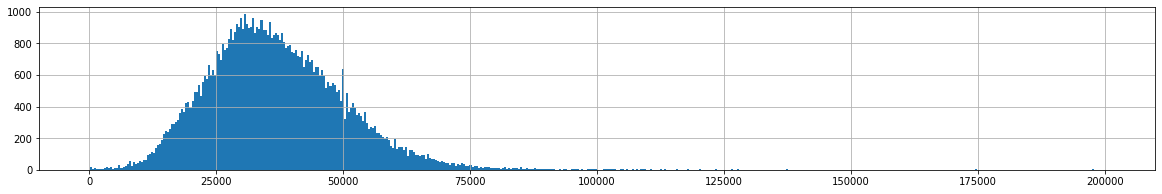

In [15]:
#inspect square meters price
gdf['square_meters_price'].hist(bins=500)

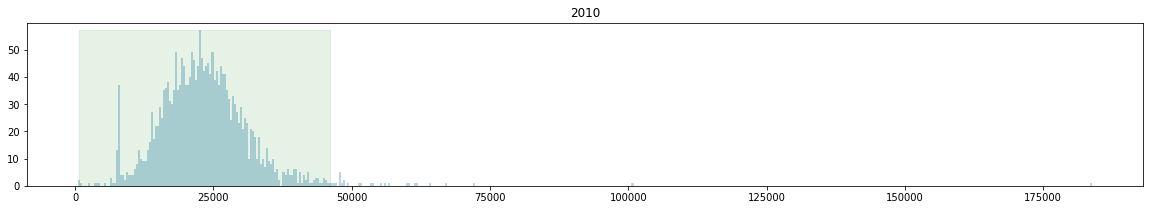

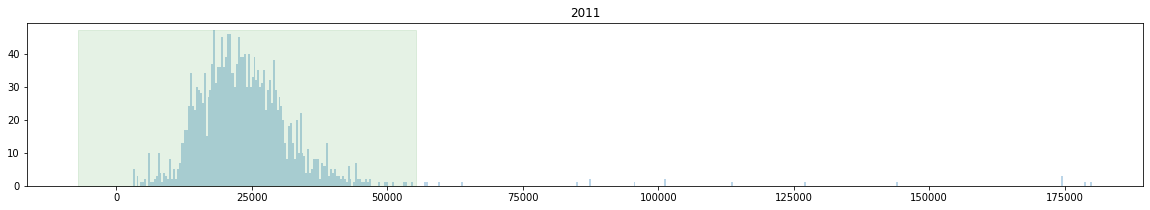

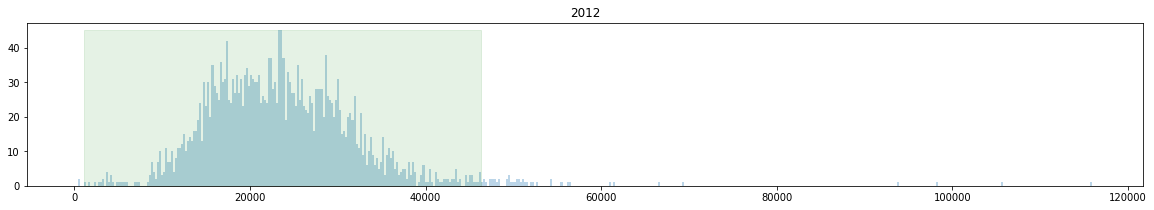

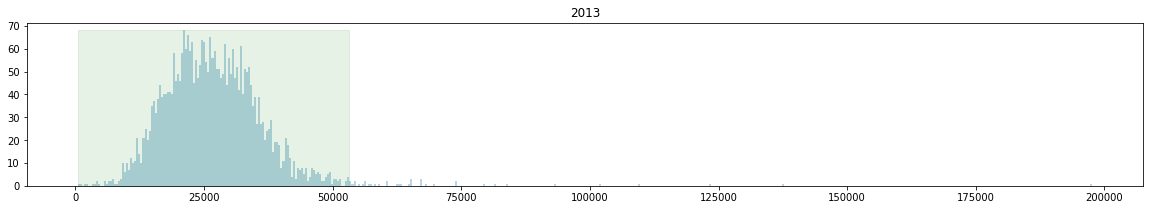

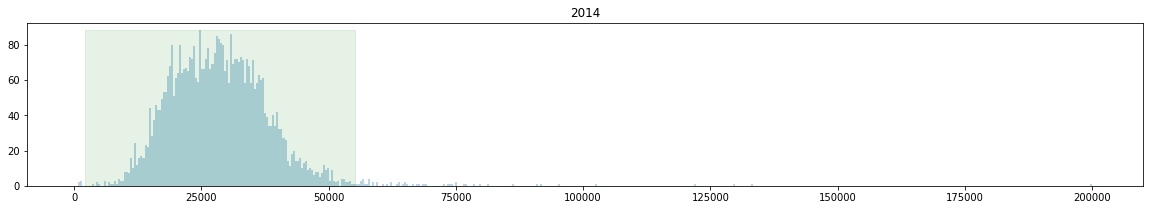

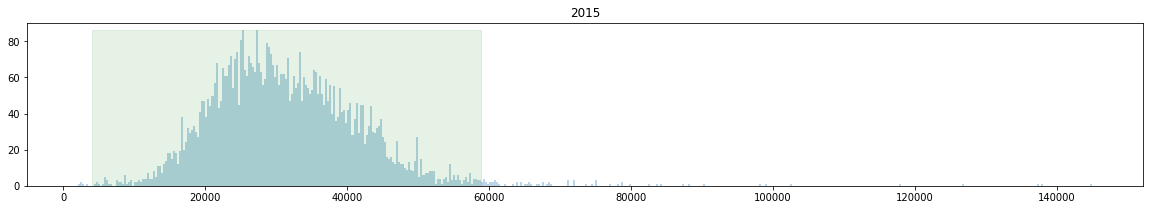

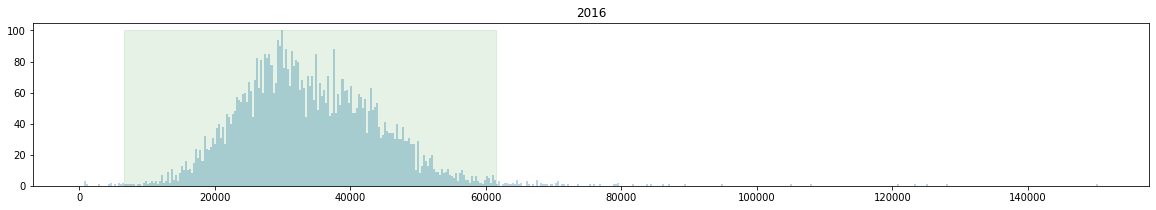

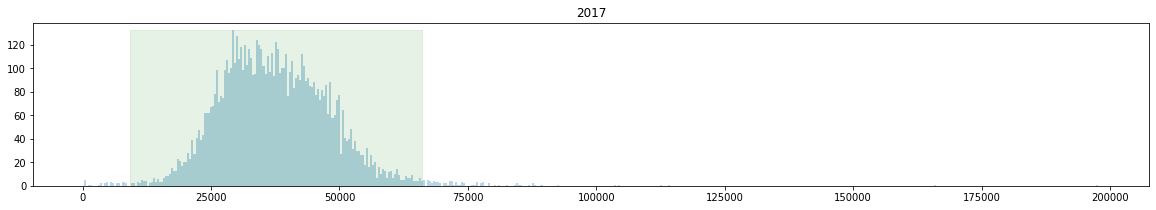

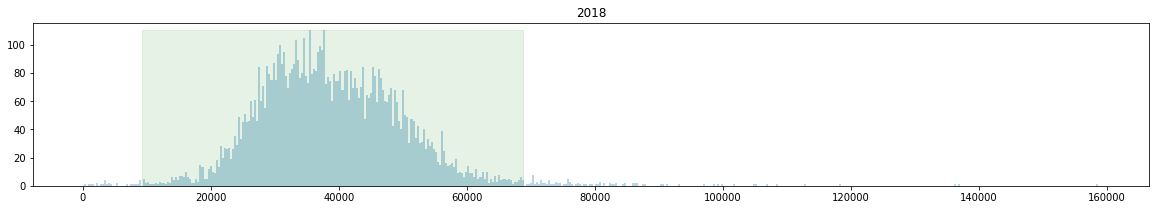

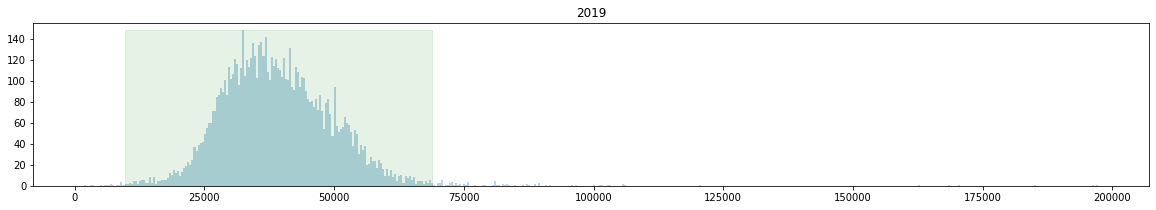

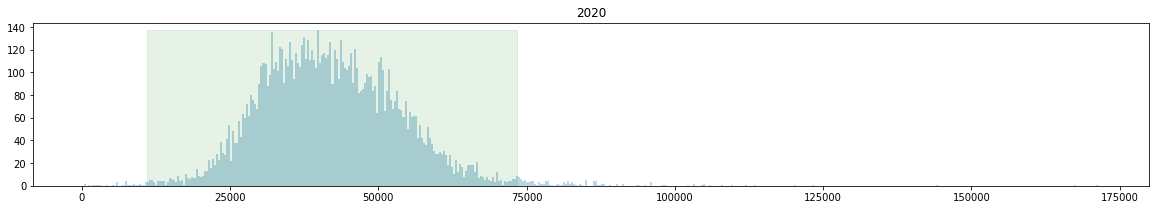

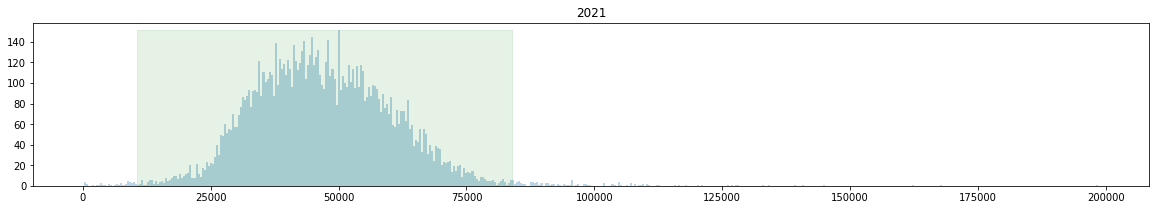

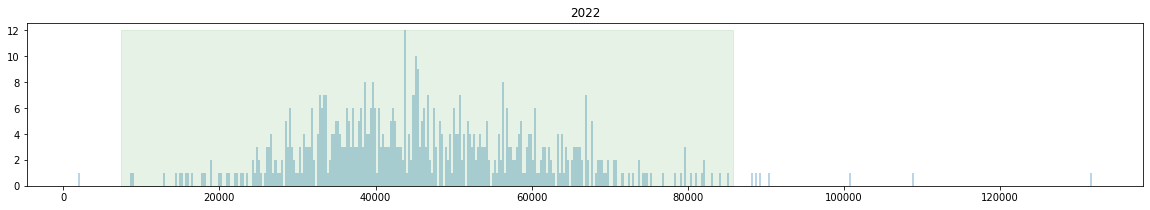

In [16]:
#inspect sq meter price per year with confidence intervals
years = sorted(list(set(gdf.year.tolist())))

#loop through each year
for year in years:
    
    #confidence interval
    ci = norm(*norm.fit(gdf[gdf['year'] == year]['square_meters_price'])).interval(0.99)
    
    #filter gdf on year
    data = gdf[gdf['year'] == year]['square_meters_price']
    
    #histogram
    height, bins, patches = plt.hist(data,bins=500, alpha=0.3)
    
    #fill confidence interval
    plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1)

    plt.title(year)
    plt.show()

<AxesSubplot:xlabel='year'>

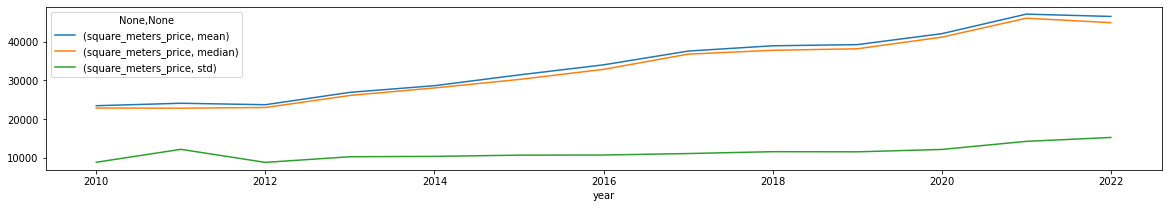

In [17]:
#plot yearly mean, median, std of square_meters_price
gdf.groupby('year').agg({'square_meters_price':['mean','median','std']}).plot()

In [18]:
#store median square meters price
grouped = gdf.groupby('year').agg({'square_meters_price':'median'}).reset_index()

In [19]:
#get 2022 median
median_2022 = grouped[grouped['year'] == '2022']['square_meters_price'].tolist()[0]

In [20]:
#compute factor to 2022 median for each year
grouped['factor'] = median_2022/grouped['square_meters_price']
grouped['year'] = grouped['year'].astype(str)

In [21]:
#make sure year is string
gdf['year'] = gdf['year'].astype(str)

In [22]:
#join factor on to gdf
gdf = gdf.merge(grouped[['factor','year']],on='year')

In [23]:
#compute 2022_adjusted_sqm_price for each apartment
gdf['2022_adjusted_sqm_price'] = gdf['square_meters_price'].astype(float)*gdf['factor'].astype(float)

<AxesSubplot:>

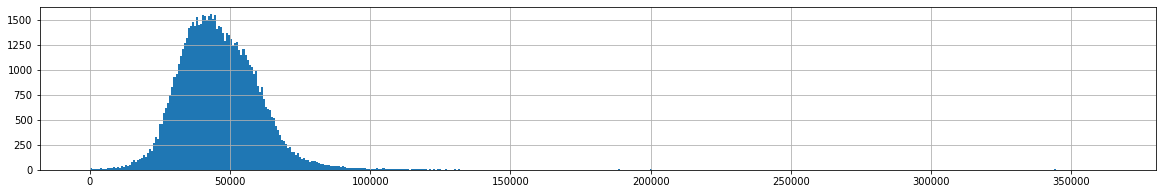

In [24]:
#inspect adjusted sqm_prices
gdf['2022_adjusted_sqm_price'].hist(bins=500)

<AxesSubplot:>

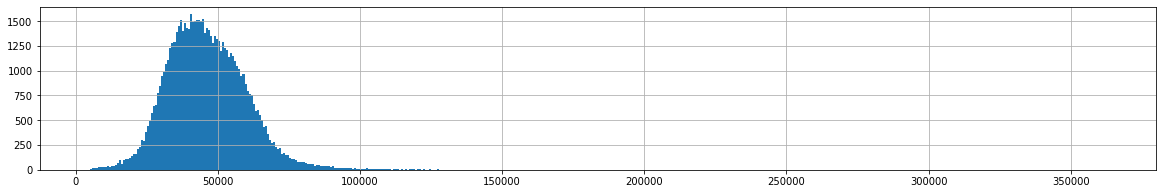

In [25]:
#adjusted sqm_prices above 5000
gdf[gdf['2022_adjusted_sqm_price'] > 5000]['2022_adjusted_sqm_price'].hist(bins=500)

In [26]:
#filter out all apartments with adjusted sqm price less than 5000 DKK
gdf = gdf[gdf['2022_adjusted_sqm_price'] > 5000]

In [27]:
#store final_final to csv for analysis
gdf.to_csv('data/final_final_data.csv')

In [28]:
with open('data/final_geodataframe.geojson', 'w') as out:
    out.write(gdf.to_json())

# Min_dist_to Investigations

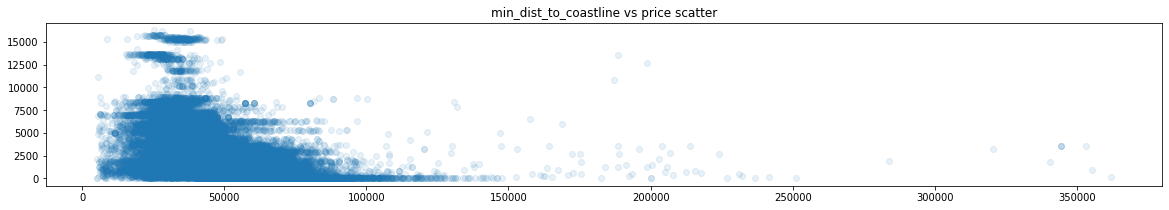

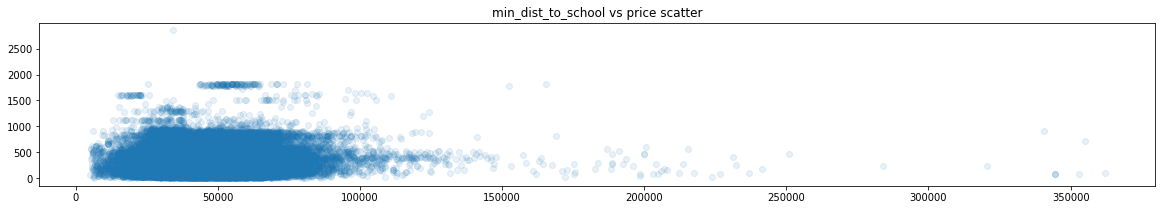

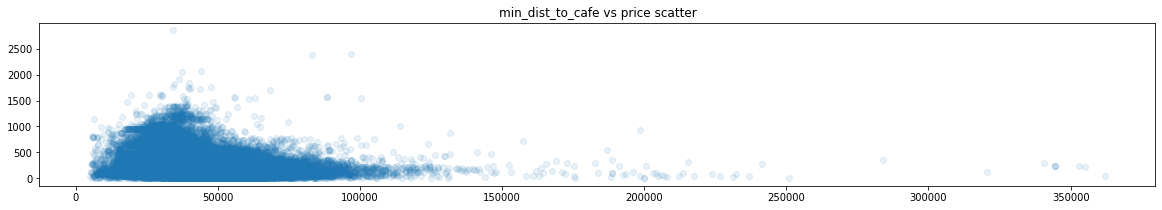

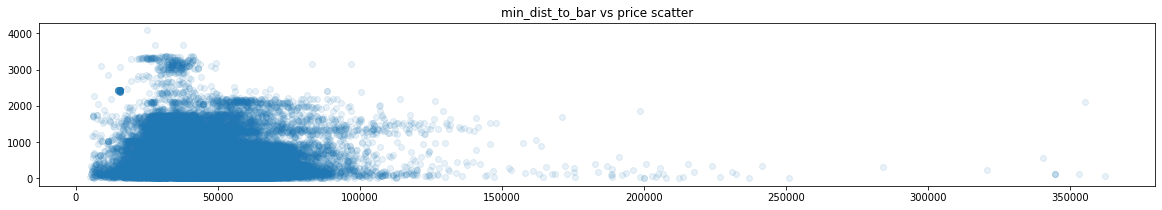

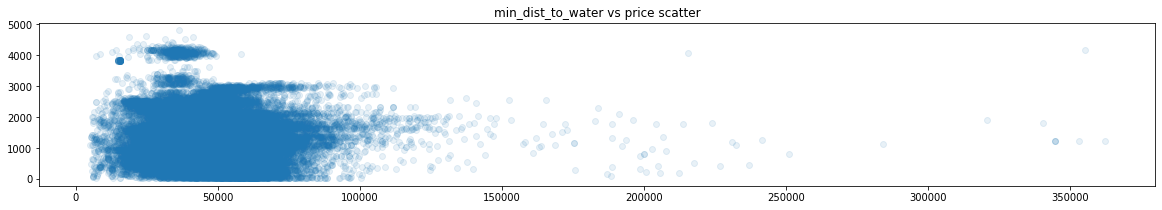

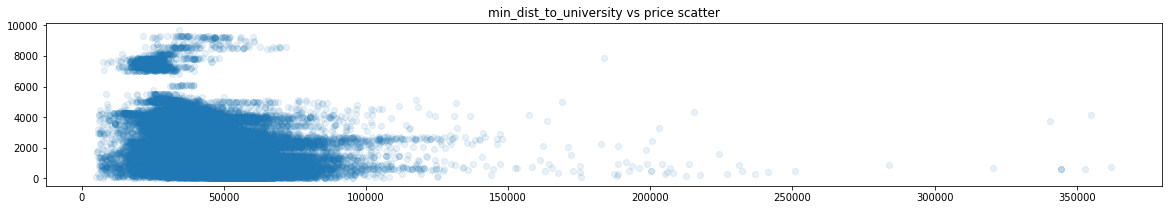

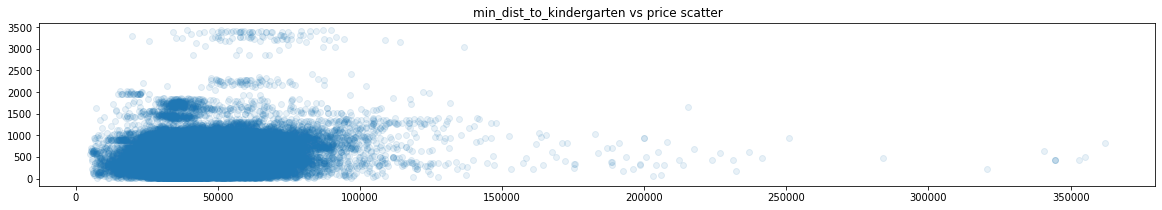

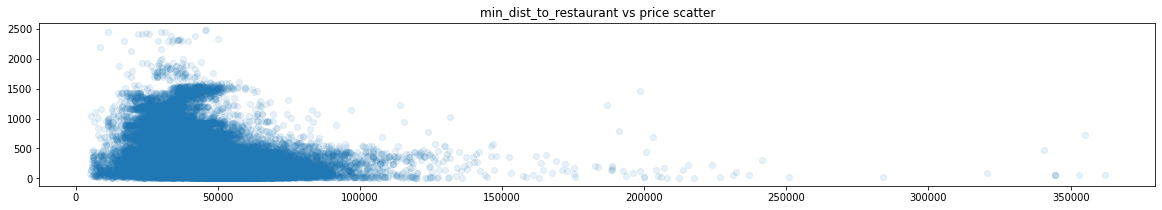

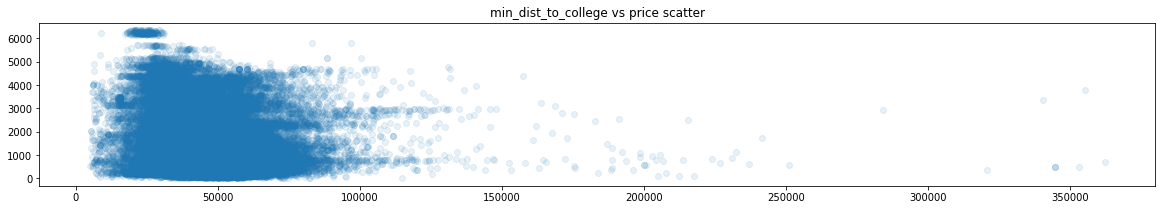

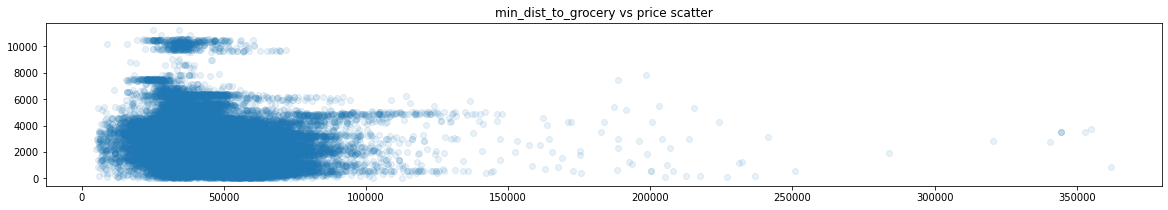

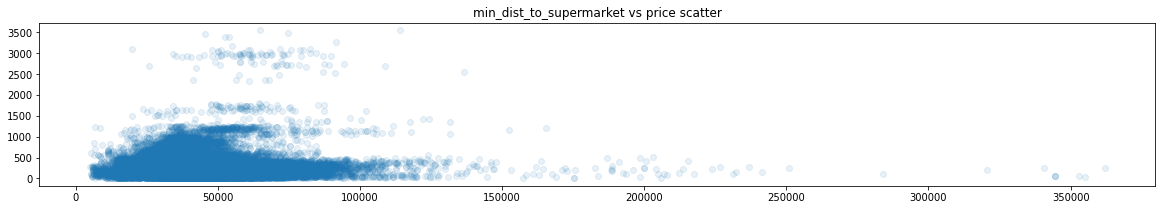

In [75]:
for t in types:
    string = 'min_dist_to_' + t
    #gdf[string].hist(bins=200)
    plt.scatter(x=gdf['2022_adjusted_sqm_price'],y=gdf[string].values,alpha=.1)
    plt.title(string + ' vs price scatter')
    plt.show()

In [62]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 8)
    return pvalues

In [58]:
columns = []
for t in types:
    string = 'min_dist_to_' + t
    columns.append(string)
    
columns.append('2022_adjusted_sqm_price')

In [59]:
subset_columns = gdf[columns]

In [60]:
subset_columns.corr()

,min_dist_to_coastline,min_dist_to_school,min_dist_to_cafe,min_dist_to_bar,min_dist_to_water,min_dist_to_university,min_dist_to_kindergarten,min_dist_to_restaurant,min_dist_to_college,min_dist_to_grocery,min_dist_to_supermarket,2022_adjusted_sqm_price
min_dist_to_coastline,1.000000,-0.003251,0.370050,0.277163,-0.217958,0.328234,-0.164588,0.297599,0.261789,0.232270,0.128886,-0.437158
min_dist_to_school,-0.003251,1.000000,0.175087,0.296050,0.059260,0.184643,0.274210,0.270487,0.156492,0.092400,0.207801,0.022121
min_dist_to_cafe,0.370050,0.175087,1.000000,0.459574,0.036471,0.396155,0.065215,0.504362,0.362331,0.230606,0.335693,-0.327613
min_dist_to_bar,0.277163,0.296050,0.459574,1.000000,-0.006521,0.414514,0.306928,0.375702,0.518896,0.267800,0.296044,-0.117763
min_dist_to_water,-0.217958,0.059260,0.036471,-0.006521,1.000000,0.132125,0.217041,-0.010832,0.044622,0.238277,0.048274,-0.022171
min_dist_to_university,0.328234,0.184643,0.396155,0.414514,0.132125,1.000000,0.182657,0.414520,0.609955,0.399092,0.278727,-0.348374
min_dist_to_kindergarten,-0.164588,0.274210,0.065215,0.306928,0.217041,0.182657,1.000000,0.018760,0.274557,0.095721,0.310212,0.146998
min_dist_to_restaurant,0.297599,0.270487,0.504362,0.375702,-0.010832,0.414520,0.018760,1.000000,0.260594,0.359673,0.339835,-0.310490
min_dist_to_college,0.261789,0.156492,0.362331,0.518896,0.044622,0.609955,0.274557,0.260594,1.000000,0.161546,0.217901,-0.223952
min_dist_to_grocery,0.232270,0.092400,0.230606,0.267800,0.238277,0.399092,0.095721,0.359673,0.161546,1.000000,0.224750,-0.216727


In [63]:
calculate_pvalues(subset_columns)

,min_dist_to_coastline,min_dist_to_school,min_dist_to_cafe,min_dist_to_bar,min_dist_to_water,min_dist_to_university,min_dist_to_kindergarten,min_dist_to_restaurant,min_dist_to_college,min_dist_to_grocery,min_dist_to_supermarket,2022_adjusted_sqm_price
min_dist_to_coastline,0.0,0.384482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min_dist_to_school,0.384482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min_dist_to_cafe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min_dist_to_bar,0.0,0.0,0.0,0.0,0.081071,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min_dist_to_water,0.0,0.0,0.0,0.081071,0.0,0.0,0.0,0.003759,0.0,0.0,0.0,0.0
min_dist_to_university,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min_dist_to_kindergarten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.0,0.0,0.0,0.0
min_dist_to_restaurant,0.0,0.0,0.0,0.0,0.003759,0.0,0.000001,0.0,0.0,0.0,0.0,0.0
min_dist_to_college,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min_dist_to_grocery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plots

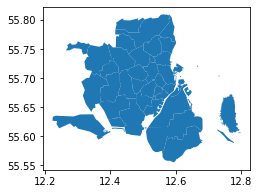

In [30]:
ax = filtered_postnumre.plot()
#ax.scatter(df.lat,df.lng)

In [33]:
with open('data/filtered_postnumre.geojson', 'w') as out:
    out.write(filtered_postnumre.to_json())

In [ ]:
#store the ax, keep only postal codes that we have in the data set
#plot all apartments for sale
ax = filtered_postnumre.plot()
gdf.plot(color='red', ax=ax,alpha=0.025,marker='.')

<AxesSubplot:>

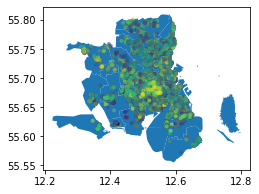

In [64]:
#cm = plt.cm.get_cmap('YlGn')
cm = plt.cm.get_cmap('viridis')
ax = postnumre[postnumre['POSTNR_TXT'].isin(postal_strings)].plot()
gdf.plot(ax=ax,alpha=0.25,marker='.',c='2022_adjusted_sqm_price',cmap=cm,legend=True)

<AxesSubplot:>

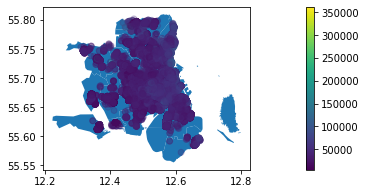

In [66]:
ax = postnumre[postnumre['POSTNR_TXT'].isin(postal_strings)].plot()
gdf.plot(ax=ax,column='2022_adjusted_sqm_price', cmap=cm, legend=True,alpha=.25)

# Streamlit plots

In [2]:
#plot makes the notebook too big to push
if False:
    import pydeck as pdk

    #https://deckgl.readthedocs.io/en/latest/gallery/column_layer.html
    view = pdk.data_utils.compute_view(gdf[["lng", "lat"]])
    view.pitch = 75
    view.bearing = 60

    column_layer = pdk.Layer(
        "ColumnLayer",
        data=gdf,
        get_position=["lng", "lat"],
        get_elevation="square_meters_price/1000",
        elevation_scale=20,
        radius=35,
        get_fill_color=[255,255,"square_meters_price/1000"],
        #[180, 0, 200, 140],
        #[255, "square_meters_price/100", "square_meters_price/10000", 140],
        pickable=True,
        auto_highlight=True,
    )

    tooltip = {
        "html": "<b>{city}</b>, costs <b>{square_meters_price}</b> price pr sq meter",
        "style": {"background": "grey", "color": "white", "font-family": '"Helvetica Neue", Arial', "z-index": "10000"},
    }


    r = pdk.Deck(
        column_layer,
        initial_view_state=view, 
        tooltip=tooltip,
        map_provider="carto",
        #map_style=pdk.map_styles.SATELLITE,
    )

    r.to_html("column_layer.html")